# Load Library

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
from tqdm import tqdm
import os
import data_utils
import model_utils
from attack_utils import get_CSMIA_case_by_case_results, CSMIA_attack, LOMIA_attack, get_LOMIA_results
from data_utils import oneHotCatVars, filter_random_data_by_conf_score
from vulnerability_score_utils import get_vulnerability_score, draw_hist_plot
from experiment_utils import MIAExperiment
from disparity_inference_utils import get_confidence_array, draw_confidence_array_scatter, get_indices_by_group_condition, get_corr_btn_sens_and_out_per_subgroup, get_slopes, get_angular_difference, calculate_stds, get_mutual_info_btn_sens_and_out_per_subgroup
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network._base import ACTIVATIONS
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate
import pickle
# import utils
import copy
from scipy.stats import kendalltau, spearmanr

import matplotlib as mpl

# Setting the font family, size, and weight globally
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 8
mpl.rcParams['font.weight'] = 'light'

In [46]:
subgroup_vals = [1, 2, 3, 4, 6, 20, 50, 51, 62, 63]
experiment = MIAExperiment(sampling_condition_dict = 
    {
            'subgroup_col_name': 'PAT_STATUS',
            'subgroup_values': subgroup_vals,
            # 'subgroup_values': ['1', '2', '3', '4', '6', '20', '50', '51', '62', '63'],
            'n': 10000
    }, shortname = f"Corr_btn_sens_and_output_for_PAT_STATUS_ranging_from_0_to_-0.5", name='Texas100', sensitive_column='SEX_CODE'
)

# experiments = { f"corr_btn_sens_and_out_{(i, j)}":  MIAExperiment(sampling_condition_dict = 
#     {
#             'correlation': 0,
#             'subgroup_col_name': 'SEX_CODE',
#             'marginal_prior': 1,
#             'corr_btn_sens_and_output_per_subgroup': (i, j),
#             # 'fixed_corr_in_test_data': True
#     }, shortname = f"Corr_btn_sens_and_output_for_male_({i})_for_female_({j})", name='Texas100', sensitive_column='ETHNICITY'
# ) for (i, j) in [(k, k) for k in [-0.4, -0.35, -0.3, -0.25, -0.2][:1]]}
# # ) for i in [-0.4, -0.3, -0.2, -0.1, 0][:1] for j in [-0.4, -0.3, -0.2, -0.1, 0][3:4]}

 10%|█         | 1/10 [00:00<00:03,  2.51it/s]

before scaling: 2625 2188 2375
after scaling: 2188 2188 1.0
before scaling: 1979 1363 1.4519442406456347
after scaling: 1363 1363 1.0
before scaling: 2375 1990 2625
after scaling: 1990 1990 1.0
before scaling: 2199 1170 1.8794871794871795
after scaling: 1170 1170 1.0


 30%|███       | 3/10 [00:01<00:02,  2.77it/s]

before scaling: 2875 1347 2125
after scaling: 1347 1347 1.0
before scaling: 995 815 1.2208588957055215
after scaling: 815 815 1.0
before scaling: 2125 1800 2875
after scaling: 1800 1800 1.0
before scaling: 2435 1295 1.8803088803088803
after scaling: 1295 1295 1.0


 50%|█████     | 5/10 [00:01<00:01,  2.81it/s]

before scaling: 1875 1492 1.2567024128686326
after scaling: 1492 1492 1.0
before scaling: 3125 1789 1.74678591391839
after scaling: 1789 1789 1.0


 60%|██████    | 6/10 [00:02<00:01,  2.81it/s]

before scaling: 3250 1346 1750
after scaling: 1346 1346 1.0
before scaling: 724 693 1.0447330447330447
after scaling: 693 693 1.0
before scaling: 1750 1568 3250
after scaling: 1568 1568 1.0
before scaling: 2912 924 3.1515151515151514
after scaling: 924 924 1.0


 70%|███████   | 7/10 [00:02<00:01,  2.74it/s]

before scaling: 3375 1548 1625
after scaling: 1548 1548 1.0
before scaling: 745 640 1.1640625
after scaling: 640 640 1.0
before scaling: 3376 963 3.5057113187954307
after scaling: 963 963 1.0


100%|██████████| 10/10 [00:03<00:00,  2.74it/s]

before scaling: 3625 2288 1.5843531468531469
after scaling: 2288 2288 1.0
[5000, 5000, 2869, 2228, 5000, 5000, 1918, 2252, 5000, 5000, 3978, 2862, 1981, 1421, 1969, 1426, 5000, 5000, 5000, 3155]


In [47]:
save_model = False

print(f"Training classifier for experiment: {experiment}")
try:
    experiment.clf = model_utils.load_model(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_modell.pkl')
    print(f"Loaded classifier for experiment from file: {experiment}")
except:
    # clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(256, 256))
    experiment.clf = model_utils.get_model(max_iter=500)
    experiment.clf.fit(experiment.X_train, experiment.y_tr_onehot)

    if save_model:
        model_utils.save_model(experiment.clf, f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model.pkl')

Training classifier for experiment: Texas100_subgroup_col_name_PAT_STATUS_subgroup_values_[1, 2, 3, 4, 6, 20, 50, 51, 62, 63]_n_10000


In [48]:
experiment.confidence_array = get_confidence_array(experiment, experiment.X_train, experiment.y_tr, experiment.clf)
sens_pred_CSMIA, case_indices = CSMIA_attack(experiment.clf, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)
case_2_indices = case_indices[2]
experiment.confidence_array_case_2 = experiment.confidence_array[case_2_indices, :]
experiment.X_case_2 = experiment.X_train.loc[case_2_indices].copy().reset_index(drop=True)
experiment.y_case_2 = experiment.y_tr.ravel()[case_2_indices]
experiment.sens_val_ground_truth = experiment.X_train[[f'{experiment.sensitive_column}_1']].to_numpy().ravel()
experiment.sens_pred_CSMIA = sens_pred_CSMIA

# Estimation of Correlation

In [17]:
def calculate_ang_diff(n=1000, random_state=1):
    correlation_vs_ang_diff = {}
    sensitive_column_index = list(experiment.X_train.columns).index(f'{experiment.sensitive_column}_1')
    conditions =  [{'PAT_STATUS': i} for i in subgroup_vals]
    for i, condition in enumerate(conditions):
        fcondition = f'{condition}'
        indices = get_indices_by_group_condition(experiment.X_case_2, condition)
        angular_difference = get_angular_difference(experiment, experiment.confidence_array_case_2[indices], experiment.y_case_2[indices])
        correlation_vs_ang_diff[fcondition] = {}
        correlation_vs_ang_diff[fcondition]['angular_difference'] = angular_difference
        correlation_vs_ang_diff[fcondition]['subgroup_val'] = condition['PAT_STATUS']

    correlation_vs_ang_diff_df = pd.DataFrame.from_dict(correlation_vs_ang_diff, orient='index')

    pat_status_vals_sorted = correlation_vs_ang_diff_df.sort_values(by='angular_difference', ascending=False)[['subgroup_val']].to_numpy().ravel().tolist()
    conditions =  [{'PAT_STATUS': pat_status_vals_sorted[:j]} for j in range(2, 7)] + [{'PAT_STATUS': pat_status_vals_sorted[j:]} for j in range(2, 7)] + [{'PAT_STATUS': i} for i in subgroup_vals]
    temp_df = experiment.X_train.copy()
    temp_df[f'{experiment.sensitive_column}_1'] = experiment.sens_pred_CSMIA
    sample_indices = experiment.X_train.sample(n=n, random_state=random_state).index
    for i, condition in enumerate(conditions):
        fcondition = f'{condition}'
        correlation_p = get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_train.loc[sample_indices].copy().reset_index(drop=True), experiment.y_tr[sample_indices], condition)
        correlation = get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_train, experiment.y_tr, condition)
        
        correlation_prediction = get_corr_btn_sens_and_out_per_subgroup(experiment, temp_df, experiment.y_tr, condition)
        indices = get_indices_by_group_condition(experiment.X_case_2, condition)
        angular_difference = get_angular_difference(experiment, experiment.confidence_array_case_2[indices], experiment.y_case_2[indices])
        correlation_vs_ang_diff[fcondition] = {}
        correlation_vs_ang_diff[fcondition]['correlation'] = correlation
        correlation_vs_ang_diff[fcondition]['correlation_p'] = correlation_p
        correlation_vs_ang_diff[fcondition]['correlation_prediction'] = correlation_prediction
        # correlation_vs_ang_diff[fcondition]['mutual_info'] = mutual_info
        correlation_vs_ang_diff[fcondition]['angular_difference'] = angular_difference
        correlation_vs_ang_diff[fcondition]['single_state'] = 0 if isinstance(condition['PAT_STATUS'], list) else 1

    correlation_vs_ang_diff_df = pd.DataFrame.from_dict(correlation_vs_ang_diff, orient='index')
    correlation_vs_ang_diff_df = correlation_vs_ang_diff_df.fillna(0)
    return correlation_vs_ang_diff_df

In [10]:
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

known_corr_index=50

def fit_regression_line():
    # conditions_new = 
    temp_df = correlation_vs_ang_diff_df[correlation_vs_ang_diff_df['single_state']==0]
    regression_x = temp_df[['angular_difference']].values
    regression_y = temp_df[['correlation_p']].values

    reg_model = LinearRegression()
    reg_model.fit(regression_x, regression_y)

    correlation_vs_ang_diff_df['correlation_estimated'] = reg_model.predict(correlation_vs_ang_diff_df[['angular_difference']].values)

def estimation_performance(pred_col_name = 'correlation_estimated'):
    temp_df = correlation_vs_ang_diff_df[correlation_vs_ang_diff_df['single_state']==1]
    true_corr = temp_df['correlation']
    pred_corr = temp_df[pred_col_name]

    mae = mean_absolute_error(true_corr, pred_corr)
    mse = mean_squared_error(true_corr, pred_corr)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_corr, pred_corr)

    return np.array([mae, mse, rmse, r2])

In [72]:
results = np.zeros((5, 4))
results_baseline = np.zeros((5, 4))


for random_state in range(5):
    correlation_vs_ang_diff_df = calculate_ang_diff(n=200, random_state=random_state)
    fit_regression_line()
    results[random_state] = estimation_performance()
    results_baseline[random_state] = estimation_performance(pred_col_name = 'correlation_p')


In [73]:
np.mean(results, axis=0).round(4)

array([0.0944, 0.0124, 0.1069, 0.3814])

In [74]:
np.std(results, axis=0).round(4)

array([0.0309, 0.0068, 0.0313, 0.3369])

In [75]:
np.mean(results_baseline, axis=0).round(4)

array([ 0.19  ,  0.0521,  0.2245, -1.5944])

In [64]:
np.std(results_baseline, axis=0).round(4)

array([0.0344, 0.0198, 0.0413, 0.9877])

# Disparity Inference

In [160]:
experiment.sens_pred_LOMIA = LOMIA_attack(experiment, experiment.clf, experiment.X_train, experiment.y_tr, experiment.ds.ds.meta)

In [164]:
import re

def get_perf(input_string):

    # Use regular expression to extract the number inside parenthesis
    match = re.search(r'\(([\d.]+)\)', input_string)

    if match:
        extracted_number = match.group(1)
        return(float(extracted_number))
    else:
        return(np.nan)

sub_size_df = get_CSMIA_case_by_case_results(experiment.clf, experiment.X_test, experiment.y_te, experiment.ds, 'PAT_STATUS', metric='accuracy', sensitive_col_name=None, subgroup_vals=subgroup_vals)
baseline_res = {val: get_perf(sub_size_df.loc['Case All Cases', val]) for val in subgroup_vals}

In [165]:
correlation_vs_ang_diff = {}
for i in subgroup_vals:
    condition = {'PAT_STATUS': i}
    fcondition = f'{condition}'
    try:
        indices = get_indices_by_group_condition(experiment.X_case_2, condition)
    except:
        continue
    correlation = get_corr_btn_sens_and_out_per_subgroup(experiment, experiment.X_train, experiment.y_tr, condition)
    if (len(indices)==0):
        continue
    angular_difference = get_angular_difference(experiment, experiment.confidence_array_case_2[indices], experiment.y_case_2[indices])
    correlation_vs_ang_diff[fcondition] = {}
    correlation_vs_ang_diff[fcondition]['correlation'] = correlation
    correlation_vs_ang_diff[fcondition]['angular_difference'] = angular_difference
    indices = get_indices_by_group_condition(experiment.X_train, condition)
    correlation_vs_ang_diff[fcondition]['CSMIA_attack_accuracy'] = (experiment.sens_val_ground_truth[indices] == experiment.sens_pred_CSMIA[indices]).sum()/len(indices)
    correlation_vs_ang_diff[fcondition]['LOMIA_attack_accuracy'] = (experiment.sens_val_ground_truth[indices] == experiment.sens_pred_LOMIA[indices]).sum()/len(indices)
    correlation_vs_ang_diff[fcondition]['baseline_attack_accuracy'] = baseline_res[i]


In [166]:
correlation_vs_ang_diff_df = pd.DataFrame.from_dict(correlation_vs_ang_diff, orient='index')

In [167]:
attacks = ['CSMIA', 'LOMIA']
metrics = [kendalltau, spearmanr]
metric_name_dict = {
    kendalltau: 'Kendall Tau',
    spearmanr: 'Spearman R'
}

ranking_perf_dict = {}
for attack in attacks:
    ranking_perf_dict[attack] = {}
    for metric in metrics:
        ranking_perf_dict[attack][metric_name_dict[metric]] = {}

        for dia in ['angular_difference', 'baseline_attack_accuracy']:
            ranking_perf = metric(correlation_vs_ang_diff_df[[f'{attack}_attack_accuracy']].to_numpy(), correlation_vs_ang_diff_df[[dia]].to_numpy())
            ranking_perf_dict[attack][metric_name_dict[metric]][dia] = f'{round(ranking_perf.statistic, 4)} ({ranking_perf.pvalue:.2e})'
            # x_values = correlation_vs_ang_diff[[f'{attack}_attack_accuracy']].to_numpy()
            # ranking_perf_dict[attack][metric][dia] = metric(x_values, x_values)

In [168]:
ranking_perf_dict

{'CSMIA': {'Kendall Tau': {'angular_difference': '-0.7778 (9.46e-04)',
   'baseline_attack_accuracy': '-0.2444 (3.81e-01)'},
  'Spearman R': {'angular_difference': '-0.9273 (1.12e-04)',
   'baseline_attack_accuracy': '-0.3576 (3.10e-01)'}},
 'LOMIA': {'Kendall Tau': {'angular_difference': '-0.7778 (9.46e-04)',
   'baseline_attack_accuracy': '-0.2444 (3.81e-01)'},
  'Spearman R': {'angular_difference': '-0.9152 (2.04e-04)',
   'baseline_attack_accuracy': '-0.3939 (2.60e-01)'}}}

In [169]:
def plot_comparison(correlation_vs_ang_diff_df, x_axis_col_name='correlation', y_axis_col_name='attack_accuracy'):
    arr = correlation_vs_ang_diff_df[[x_axis_col_name, y_axis_col_name]].to_numpy()

    x_values = [item[0] for item in arr]
    y_values = [item[1] for item in arr]

    # Creating the scatter plot
    fig, ax = plt.subplots()
    plt.scatter(x_values, y_values, color='grey', alpha=0.9, marker='x')
    # plt.title('Scatter Plot of Correlation vs Angular Difference')
    plt.xlabel(f'{x_axis_col_name}')
    plt.ylabel(f'{y_axis_col_name}')
    # plt.xlim(-0.5, 0.025)
    plt.grid(True, linewidth=0.25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # sns.despine()
    plt.show()


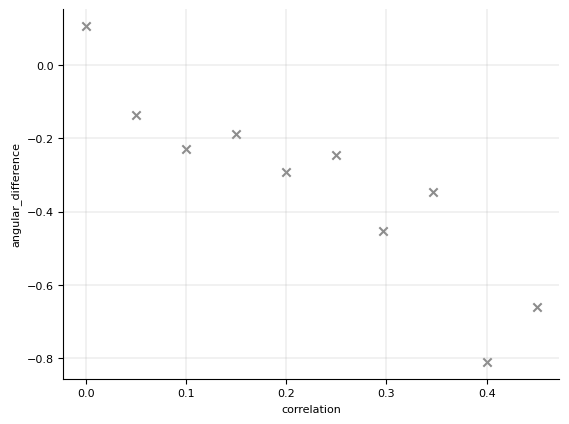

In [170]:
plot_comparison(correlation_vs_ang_diff_df, 'correlation', 'angular_difference')

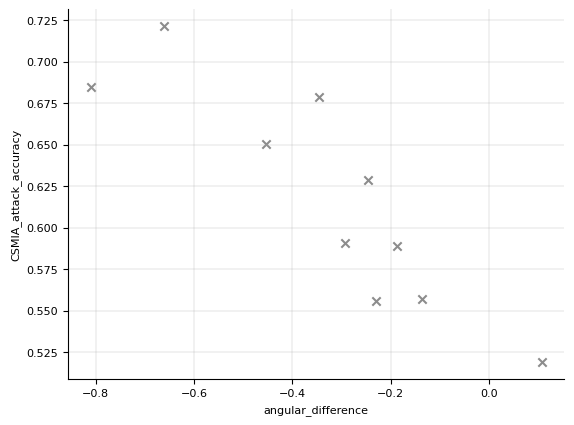

In [171]:
plot_comparison(correlation_vs_ang_diff_df, 'angular_difference', 'CSMIA_attack_accuracy')